In [143]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from operator import attrgetter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

path = Path("../data")

In [122]:
df = pd.read_parquet(path / "full_data.parquet")

In [115]:
df.churn.value_counts()[1]/(len(df))*100

7.707464276204846

Target is quite unbalanced 

In [129]:
def get_cols_to_drop():

    drop_cols = [
                'churn',
                'advertiser_zrive_id',
                'period_int',
                'month_period',
                'monthly_avg_ad_price', #has nans
                'monthly_distinct_ads', #has nans
                'monthly_avg_ad_price_3_months_mean',
                'monthly_avg_ad_price_3_months_mean_delta'
                ]

    return drop_cols


In [118]:
def split_by_date(data, execution_month, train_months = 6):
    """
    Splits data into train and test sets based on a date
    """
    df = data.sort_values('month_period')
    train_start = execution_month - pd.DateOffset(months=train_months)

    train = df[(df['month_period'] >= train_start.to_period('M')) & (df['month_period'] < execution_month.to_period('M'))]
    test = df[df['month_period'] == execution_month.to_period('M')]

    drop_cols = get_cols_to_drop()
    X_train = train.drop(columns=drop_cols)
    y_train = train['churn']
    X_test = test.drop(columns=drop_cols)
    y_test = test['churn']
    
    return X_train, X_test, y_train, y_test

In [138]:
def train_model(data, model, execution_month, train_months = 6):
    """
    Trains model and evaluates using ROC AUC and PR AUC
    """

    X_train, X_test, y_train, y_test = split_by_date(data, execution_month, train_months)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test) 

    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test


In [137]:
def evaluate_model(y_test, y_scores):
 
    roc = roc_auc_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    prc = auc(recall, precision)

    return {
        'roc_auc': roc,
        'pr_auc': prc,
    }


In [141]:
def plot_curves(y_test, y_scores):

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    prec, rec, thresholds = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(rec, prec)

    fig, axs  = plt.subplots(1,2, figsize=(12, 5))
    axs[0].plot(fpr, tpr, label= f'{model}, AUC = %.2f' % roc_auc)
    axs[1].plot(rec, prec, label= f'{model}, AUC = %.2f' % pr_auc)

    axs[0].set_title('ROC curve')
    axs[0].set_xlabel('False positive rate')
    axs[0].set_ylabel('True positive rate')
    axs[0].legend(loc="lower right")

    axs[1].set_title('Precision-recall curve')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend(loc="upper right")

In [75]:
def run_for_all_dates(data, execution_months, model, train_months = 6):
    """
    Rolls over execution_months, applies split + train/eval, returns results
    """
    results = []

    for execution_month in execution_months:
        metrics = evaluate_model(data, execution_month)
        metrics['execution_month'] = pd.to_datetime(execution_month)
        results.append(metrics)

    return pd.DataFrame(results)


In [150]:
execution_month = pd.to_datetime("2023-11-01")
model = LogisticRegression(max_iter=500)

model, X_train, X_test, y_train, y_test = train_model(df, model, execution_month, train_months)
y_scores = model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_scores)


{'roc_auc': 0.7549402573529411, 'pr_auc': 0.1416064228070409}

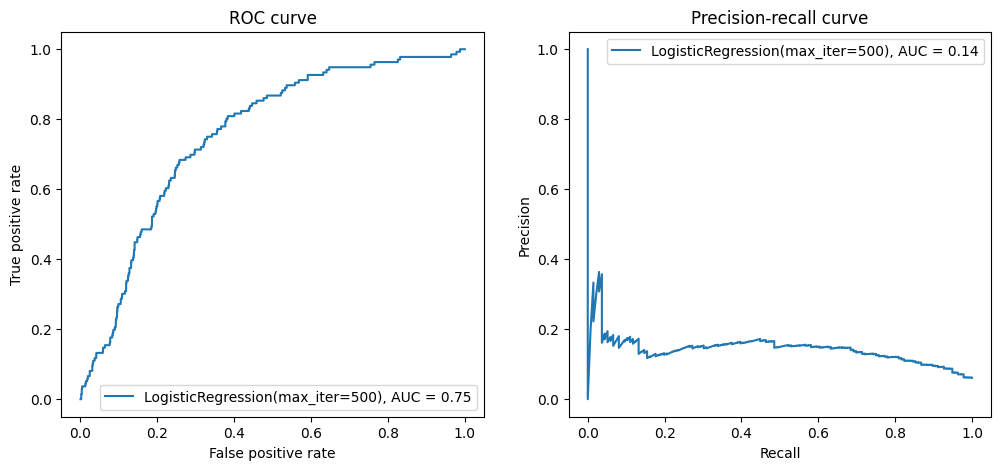

In [151]:
plot_curves(y_test, y_scores)
